In [1]:
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import AxesGrid
import yt
import sunpy.map
import synthesizAR

%matplotlib inline

/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Potential Field

In [2]:
ar_field = synthesizAR.Skeleton.restore('/storage-home/w/wtb2/data/base_noaa1158/')

No HMI fits file supplied. A new HMI map object will not be created.
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/field.py:190: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcx, rcx = self.hmi_map.xrange + self.hmi_map.scale.axis1*u.Quantity([boundary_clipping[0], -boundary_clipping[0]], u.pixel)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/field.py:191: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  lcy, rcy = self.hmi_map.yrange + self.hmi_map.scale.axis2*u.Quantity([boundary_clipping[1], -boundary_clipping[1]], u.pixel)
/storage-home/w/wtb2/anaconda3/envs/synthesizar/lib/python3.5/site-packages/synthesizAR-0.1.dev471-py3.5.egg/synthesizAR/field.py:198: SunpyDeprecationWarning: This property is only valid for non-rotated WCS
  bbox = np.array([self._convert_angle_to_length(self

yt : [INFO     ] 2017-11-20 22:41:40,686 xlim = -29793120078.254406 -11846331526.051441
yt : [INFO     ] 2017-11-20 22:41:40,687 ylim = -26209138438.247005 -7412702104.521481
yt : [INFO     ] 2017-11-20 22:41:40,688 xlim = -29793120078.254406 -11846331526.051441
yt : [INFO     ] 2017-11-20 22:41:40,689 ylim = -26209138438.247005 -7412702104.521481
yt : [INFO     ] 2017-11-20 22:41:40,690 Making a fixed resolution buffer of (('stream', 'Bz')) 800 by 800
yt : [WARNING  ] 2017-11-20 22:41:40,716 Plot image for field ('stream', 'Bz') has both positive and negative values. Min = -0.000379, Max = 0.000416.
yt : [WARNING  ] 2017-11-20 22:41:40,717 Switching to symlog colorbar scaling unless linear scaling is specified later



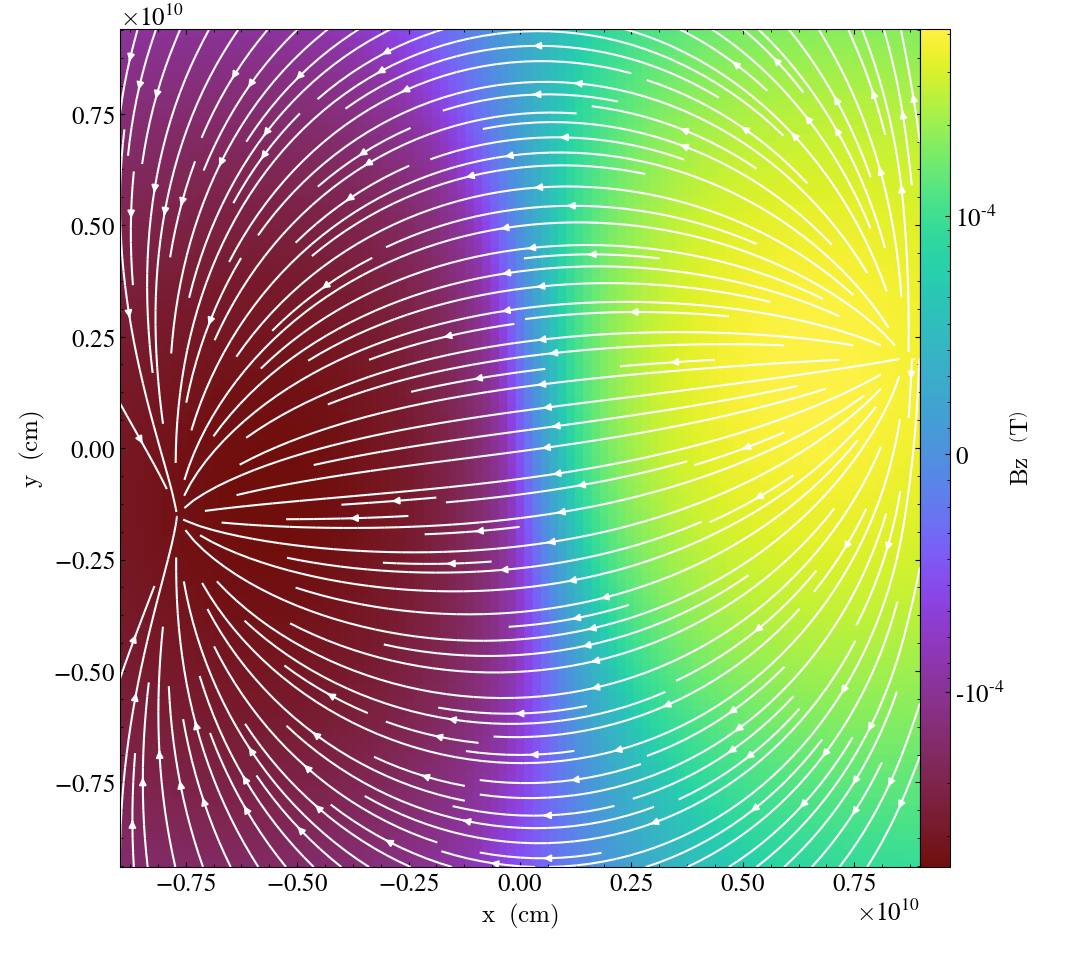

In [11]:
center=(ar_field.extrapolated_3d_field.domain_center
        +np.array([0,0,0])*ar_field.extrapolated_3d_field.domain_width)
p = yt.SlicePlot(ar_field.extrapolated_3d_field,'z','Bz',
                 origin='center-domain',
                 axes_unit='cm',
                 center=center,
                 #width=((1*ar_field.extrapolated_3d_field.domain_width.value[1],'cm'),
                 #       (ar_field.extrapolated_3d_field.domain_width.value[2],'cm'))
                )
p.annotate_streamlines('Bx','By',density=2,plot_args={'color':'w'})
#p.set_zlim('Bz',-3e-2,3e-2)
#p.set_log('Bz',True,linthresh=1e-3)
p.show()

In [ ]:
ar_field.extract_streamlines(500)

In [ ]:
ar_field.peek(alpha=0.25)

In [ ]:
ar_field.make_loops()

## Force Free Field (from friction code)

In [ ]:
bx = np.loadtxt('/home/w/wtb2/bsol_force_free_tmp/bsol/bsolution.bx',comments='//').reshape((95,95,95))
by = np.loadtxt('/home/w/wtb2/bsol_force_free_tmp/bsol/bsolution.by',comments='//').reshape((95,95,95))
bz = np.loadtxt('/home/w/wtb2/bsol_force_free_tmp/bsol/bsolution.bz',comments='//').reshape((95,95,95))

In [ ]:
ff_field = synthesizAR.Skeleton()
ff_field._zrange = ar_field._zrange
ff_field.hmi_map = ar_field.hmi_map
fake_3d_field = np.zeros(ar_field._map_3d.shape)
fake_3d_field[2:-3,2:-2,2:-3,1] = np.transpose(bx,axes=[1,2,0])
fake_3d_field[2:-3,2:-2,2:-3,0] = np.transpose(by,axes=[1,2,0])
fake_3d_field[2:-3,2:-2,2:-3,2] = np.transpose(bz,axes=[1,2,0])
ff_field._map_3d = fake_3d_field
ff_field.extrapolated_3d_field = ff_field._transform_to_yt(ff_field._map_3d,ff_field._zrange)

In [ ]:
center=(ff_field.extrapolated_3d_field.domain_center
        +np.array([0,-0.1,0])*ff_field.extrapolated_3d_field.domain_width)
p = yt.SlicePlot(ff_field.extrapolated_3d_field,'y','Bz',
                 origin='lower-right-domain',
                 axes_unit='cm',
                 center=center,
                 width=((1*ff_field.extrapolated_3d_field.domain_width.value[1],'cm'),
                        (1*ff_field.extrapolated_3d_field.domain_width.value[2],'cm'))
                )
p.annotate_streamlines('Bz','Bx',density=2,plot_args={'color':'w'})
p.set_zlim('Bz',-3e-2,3e-2)
p.set_log('Bz',True,linthresh=1e-3)
p.show()

In [ ]:
ff_field.extract_streamlines(1000,
                             mask_threshold=0.05,
                             close_threshold=0.005,
                             safety=10,
                             loop_length_range=[1e9,5e10]*u.cm
                            )

In [ ]:
ff_field.peek(alpha=0.25)

In [ ]:
ff_field.make_loops()

## Comparison

In [ ]:
plt.hist([loop.full_length.to(u.Mm).value for loop in ar_field.loops],histtype='step',lw=2,bins='scott');
plt.hist([loop.full_length.to(u.Mm).value for loop in ff_field.loops],histtype='step',lw=2,bins='scott');

In [ ]:
plt.hist([loop.field_strength.to(u.Gauss).value.mean() for loop in ar_field.loops],histtype='step',lw=2,bins='scott');
plt.hist([loop.field_strength.to(u.Gauss).value.mean() for loop in ff_field.loops],histtype='step',lw=2,bins='scott');

In [ ]:
## Setup figure
fig = plt.figure()
grid = AxesGrid(fig, (0.075,0.075,0.85,0.85),
                nrows_ncols = (3, 2),
                axes_pad = 1.2,
                label_mode = "1",
                share_all = True,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="3%",
                cbar_pad="0%")
fig.set_figwidth(30)
# Create plots
mag_fields = ['Bx','By','Bz']
p1 = yt.SlicePlot(ff_field.extrapolated_3d_field,'x',mag_fields,
                  origin='lower-right-domain',
                  #center=(ff_field.extrapolated_3d_field.domain_center
                  #        +np.array([0,0,0])*ff_field.extrapolated_3d_field.domain_width),
                  #width=((1*ff_field.extrapolated_3d_field.domain_width.value[1],'cm'),
                  #      (0.75*ff_field.extrapolated_3d_field.domain_width.value[2],'cm'))
                 )
p1.annotate_streamlines('By','Bz',plot_args={'color':'w'},density=1)
p1.figure_size = 20
[p1.set_zlim(mf,-3e-2,3e-2) for mf in mag_fields]
[p1.set_log(mf,True,linthresh=1e-3) for mf in mag_fields]
p2 = yt.SlicePlot(ar_field.extrapolated_3d_field,'x',mag_fields,
                  origin='lower-right-domain',
                  #center=(ar_field.extrapolated_3d_field.domain_center
                  #        +np.array([0,0,0])*ar_field.extrapolated_3d_field.domain_width),
                  #width=((1*ar_field.extrapolated_3d_field.domain_width.value[1],'cm'),
                  #      (0.75*ar_field.extrapolated_3d_field.domain_width.value[2],'cm'))
                 )
p2.annotate_streamlines('By','Bz',plot_args={'color':'w'},density=1)
p2.figure_size = 20
[p2.set_zlim(mf,-3e-2,3e-2) for mf in mag_fields]
[p2.set_log(mf,True,linthresh=1e-3) for mf in mag_fields]
## Add plots
for i,b_field in enumerate(mag_fields):
    plot = p1.plots[b_field]
    plot.figure = fig
    plot.axes = grid[2*i].axes
    plot.cax = grid.cbar_axes[2*i]
p1._setup_plots()
for i,b_field in enumerate(mag_fields):
    plot = p2.plots[b_field]
    plot.figure = fig
    plot.axes = grid[2*i+1].axes
    plot.cax = grid.cbar_axes[2*i+1]
p2._setup_plots()

In [ ]:
fig = plt.figure(figsize=(15,15))
m = sunpy.map.Map('/storage-home/w/wtb2/sunpy/data/hmi_m_45s_2011_02_12_15_33_45_tai_magnetogram.fits').rotate()
bottom_corner = SkyCoord(ar_field.hmi_map.bottom_left_coord.Tx,
                         ar_field.hmi_map.bottom_left_coord.Ty,
                         frame=m.coordinate_frame)
top_corner = SkyCoord(ar_field.hmi_map.top_right_coord.Tx,
                      ar_field.hmi_map.top_right_coord.Ty,
                      frame=m.coordinate_frame)
m = m.submap(bottom_corner,top_corner)
ax = fig.add_subplot(111,projection=m)
m.plot(axes=ax)
for stream, _ in ar_field.streamlines:#[::2]:
    ax.plot(ar_field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
            ar_field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
            alpha=0.25,
            color=sns.color_palette('deep')[4],
            transform=ax.get_transform('world'))
for stream, _ in ff_field.streamlines:#[::2]:
    ax.plot(ff_field._convert_angle_to_length(stream[:, 0]*u.cm,working_units=u.arcsec).to(u.deg),
            ff_field._convert_angle_to_length(stream[:, 1]*u.cm,working_units=u.arcsec).to(u.deg),
            alpha=0.25,
            color=sns.color_palette('deep')[2],
            transform=ax.get_transform('world'))